Imports

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys

sys.path.append('..')
from backend.app.data.ingestion import data_ingestion


warnings.filterwarnings('ignore')

#visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

print("✅ Imports complete")

✅ Imports complete


Loading data

In [4]:
# Define file path
data_path = Path('../backend/data_samples/sample_retail.csv')

# Try to load from file, fallback to generated data
if data_path.exists():
    print(f"📂 Loading data from: {data_path}")
    df = pd.read_csv(data_path, parse_dates=['InvoiceDate'])
    print(f"✅ Loaded {len(df):,} rows from file")
else:
    print(f"⚠️ File not found: {data_path}")
    print("🔄 Generating sample data using ingestion module...")
    df = data_ingestion.generate_sample_data(n_rows=10000)
    print(f"✅ Generated {len(df):,} rows of sample data")

# Preview first few rows
print("\n📋 First 5 rows:")
df.head()

⚠️ File not found: ..\backend\data_samples\sample_retail.csv
🔄 Generating sample data using ingestion module...
✅ Generated 10,000 rows of sample data

📋 First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,INV0000000,22745,POPPY'S PLAYHOUSE BEDROOM,2,2023-01-01 00:00:00.000000000,2.75,CUST00413,Italy
1,INV0000001,84029G,POPPY'S PLAYHOUSE LIVING ROOM,-9,2023-01-01 00:52:25.274527452,2.10,CUST00478,USA
2,INV0000002,22749,POPPY'S PLAYHOUSE BATHROOM,18,2023-01-01 01:44:50.549054905,3.39,None,France
3,INV0000003,22746,FELT TREE TRUNK,17,2023-01-01 02:37:15.823582358,2.10,CUST00068,Italy
4,INV0000004,84030E,WHITE METAL LANTERN,8,2023-01-01 03:29:41.098109810,3.75,CUST00066,United Kingdom


In [5]:
# Dataset shape
print(f"📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# Column information
print("📋 Column Information:")
for col in df.columns:
    dtype = df[col].dtype
    nunique = df[col].nunique() if dtype == 'object' else 'N/A'
    print(f"  • {col:15} | Type: {str(dtype):10} | Unique: {nunique}")

# Date range
print(f"\n📅 Date Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"   Total Days: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days}")

# Unique counts
print(f"\n🔢 Unique Counts:")
print(f"  • Customers: {df['CustomerID'].nunique():,}")
print(f"  • Products:  {df['StockCode'].nunique():,}")
print(f"  • Invoices:  {df['InvoiceNo'].nunique():,}")
print(f"  • Countries: {df['Country'].nunique():,}")

📊 Dataset Shape: 10,000 rows × 8 columns

📋 Column Information:
  • InvoiceNo       | Type: object     | Unique: 10000
  • StockCode       | Type: object     | Unique: 12
  • Description     | Type: object     | Unique: 12
  • Quantity        | Type: int32      | Unique: N/A
  • InvoiceDate     | Type: datetime64[ns] | Unique: N/A
  • UnitPrice       | Type: float64    | Unique: N/A
  • CustomerID      | Type: object     | Unique: 501
  • Country         | Type: object     | Unique: 7

📅 Date Range: 2023-01-01 00:00:00 to 2023-12-31 00:00:00
   Total Days: 364

🔢 Unique Counts:
  • Customers: 501
  • Products:  12
  • Invoices:  10,000
  • Countries: 7


Revenue & Return Analysis

💰 REVENUE ANALYSIS
Gross Sales:     $242,990.81
Returns:         $4,901.38
Net Revenue:     $238,089.43
Return Rate:     2.02%

Return Transactions: 200 (2.00% of all transactions)


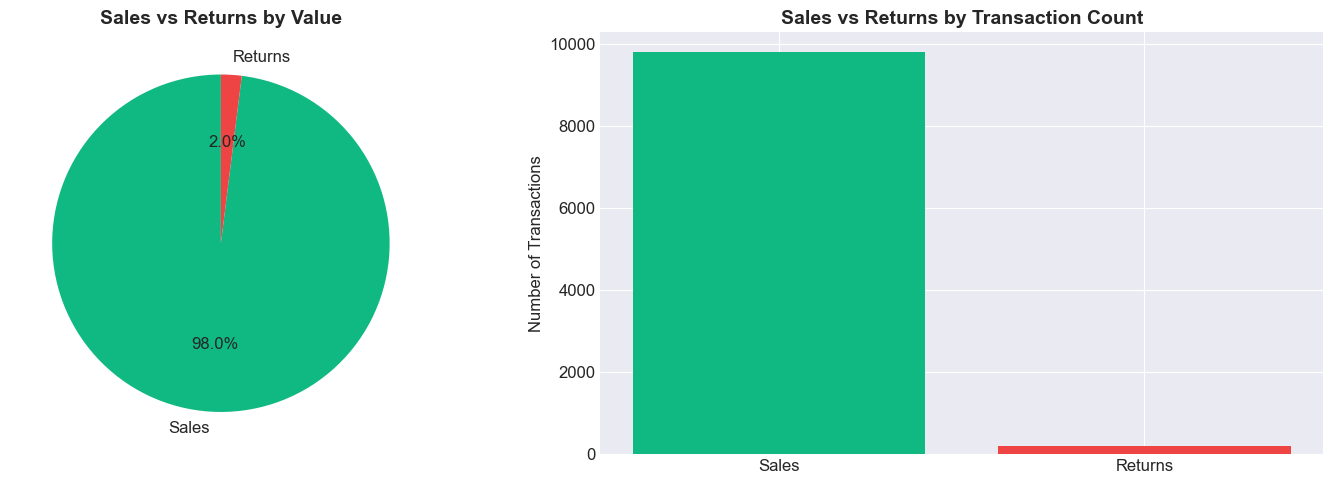

In [6]:
# Calculate revenue components (matching backend logic)
df['TransactionValue'] = df['Quantity'] * df['UnitPrice']
df['IsReturn'] = df['Quantity'] < 0

# Sales (positive quantities only)
df['SalesRevenue'] = df.apply(
    lambda row: row['TransactionValue'] if row['Quantity'] > 0 else 0,
    axis=1
)

# Returns (absolute value)
df['ReturnsValue'] = df.apply(
    lambda row: abs(row['TransactionValue']) if row['Quantity'] < 0 else 0,
    axis=1
)

# Net revenue (what actually matters)
df['NetRevenue'] = df['SalesRevenue'] - df['ReturnsValue']

# Summary statistics
total_sales = df['SalesRevenue'].sum()
total_returns = df['ReturnsValue'].sum()
net_revenue = df['NetRevenue'].sum()
return_rate = (total_returns / total_sales * 100) if total_sales > 0 else 0

print("💰 REVENUE ANALYSIS")
print("=" * 50)
print(f"Gross Sales:     ${total_sales:,.2f}")
print(f"Returns:         ${total_returns:,.2f}")
print(f"Net Revenue:     ${net_revenue:,.2f}")
print(f"Return Rate:     {return_rate:.2f}%")
print(f"\nReturn Transactions: {df['IsReturn'].sum():,} ({df['IsReturn'].mean()*100:.2f}% of all transactions)")

# Visualize sales vs returns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart of sales vs returns
labels = ['Sales', 'Returns']
sizes = [total_sales, total_returns]
colors = ['#10B981', '#EF4444']
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Sales vs Returns by Value', fontsize=14, fontweight='bold')

# Bar chart of transaction counts
return_counts = df['IsReturn'].value_counts()
axes[1].bar(['Sales', 'Returns'], return_counts.values, color=['#10B981', '#EF4444'])
axes[1].set_title('Sales vs Returns by Transaction Count', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

Distribution

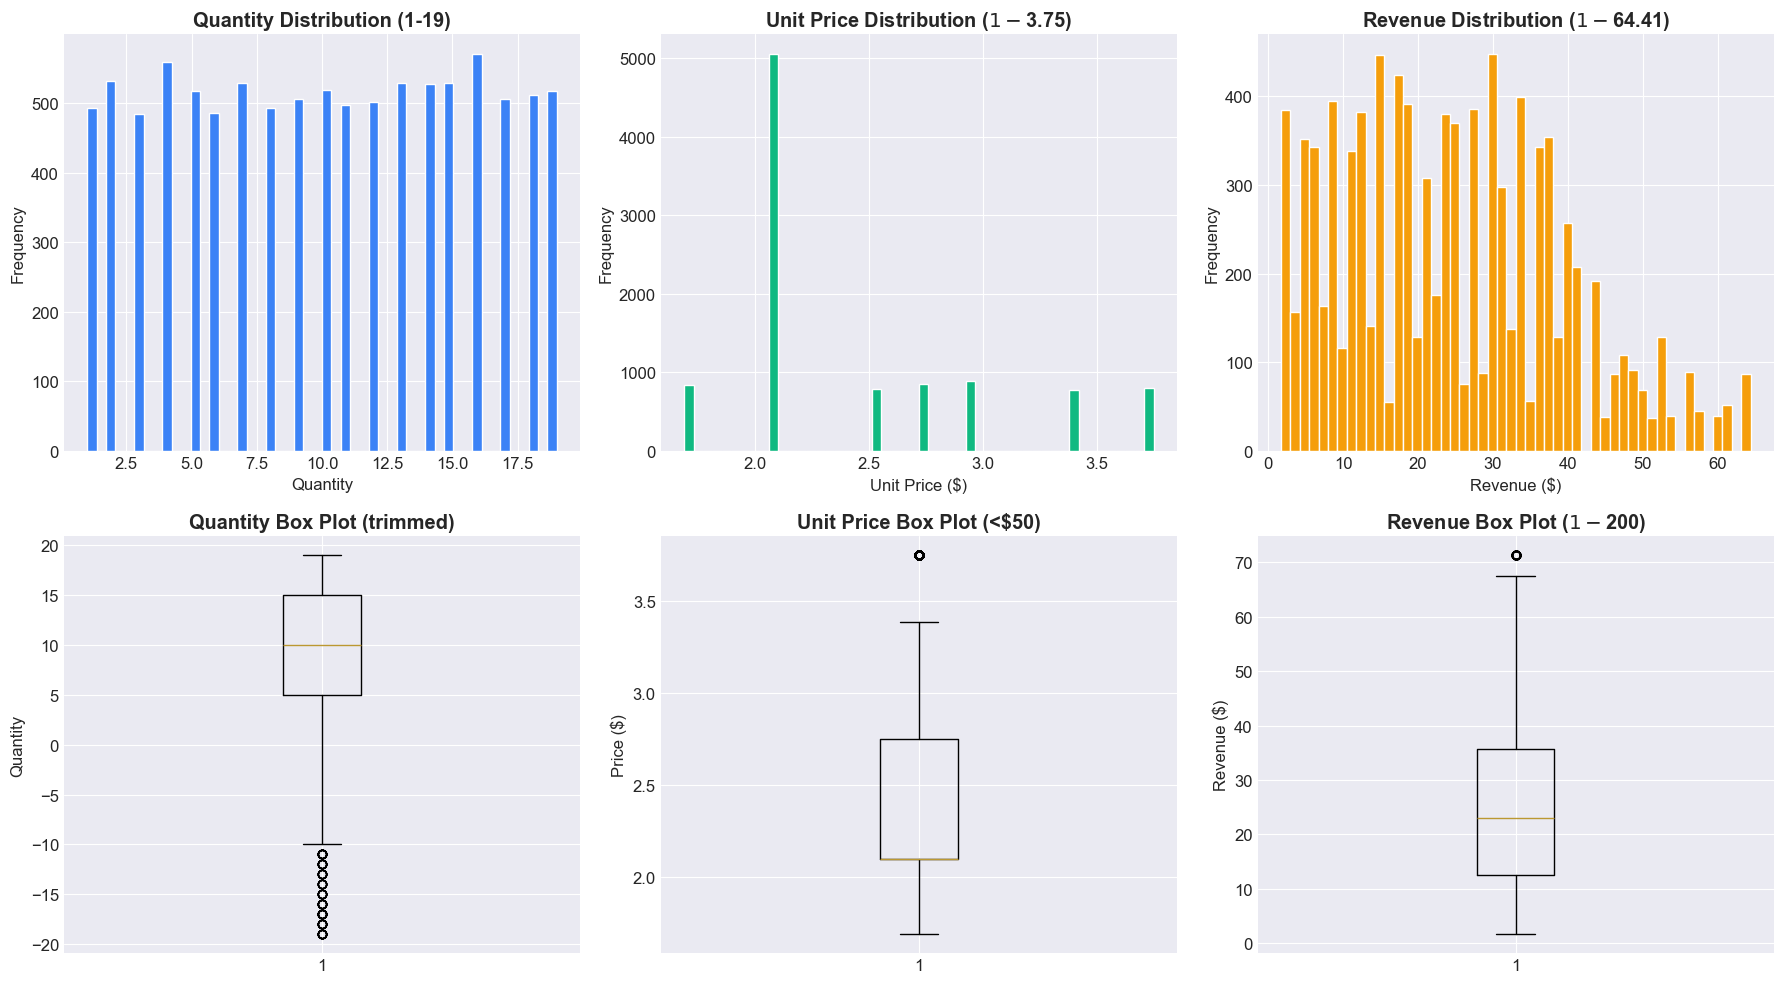

📊 SUMMARY STATISTICS


,Quantity,UnitPrice,NetRevenue
count,10000.000000,10000.000000,10000.000000
mean,9.654400,2.464127,23.808943
std,6.153564,0.587504,16.640762
min,-19.000000,1.690000,-71.250000
25%,5.000000,2.100000,11.830000
50%,10.000000,2.100000,23.100000
75%,15.000000,2.750000,35.400000
max,19.000000,3.750000,71.250000


In [7]:
# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Quantity distribution (excluding extremes)
qty_99 = df['Quantity'].quantile(0.99)
qty_normal = df[df['Quantity'].between(1, qty_99)]

axes[0, 0].hist(qty_normal['Quantity'], bins=50, color='#3B82F6', edgecolor='white')
axes[0, 0].set_title(f'Quantity Distribution (1-{qty_99:.0f})', fontweight='bold')
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Frequency')

# 2. UnitPrice distribution
price_99 = df['UnitPrice'].quantile(0.99)
price_normal = df[df['UnitPrice'].between(1, price_99)]

axes[0, 1].hist(price_normal['UnitPrice'], bins=50, color='#10B981', edgecolor='white')
axes[0, 1].set_title(f'Unit Price Distribution ($1-${price_99:.2f})', fontweight='bold')
axes[0, 1].set_xlabel('Unit Price ($)')
axes[0, 1].set_ylabel('Frequency')

# 3. Revenue distribution
revenue_99 = df['NetRevenue'].quantile(0.99)
revenue_normal = df[df['NetRevenue'].between(1, revenue_99)]

axes[0, 2].hist(revenue_normal['NetRevenue'], bins=50, color='#F59E0B', edgecolor='white')
axes[0, 2].set_title(f'Revenue Distribution ($1-${revenue_99:.2f})', fontweight='bold')
axes[0, 2].set_xlabel('Revenue ($)')
axes[0, 2].set_ylabel('Frequency')

# 4. Box plot - Quantity
axes[1, 0].boxplot(df['Quantity'][df['Quantity'].between(-50, 50)])
axes[1, 0].set_title('Quantity Box Plot (trimmed)', fontweight='bold')
axes[1, 0].set_ylabel('Quantity')

# 5. Box plot - UnitPrice
axes[1, 1].boxplot(df['UnitPrice'][df['UnitPrice'] < 50])
axes[1, 1].set_title('Unit Price Box Plot (<$50)', fontweight='bold')
axes[1, 1].set_ylabel('Price ($)')

# 6. Box plot - Revenue
axes[1, 2].boxplot(df['NetRevenue'][df['NetRevenue'].between(1, 200)])
axes[1, 2].set_title('Revenue Box Plot ($1-$200)', fontweight='bold')
axes[1, 2].set_ylabel('Revenue ($)')

plt.tight_layout()
plt.show()

# Summary statistics
print("📊 SUMMARY STATISTICS")
print("=" * 50)
stats_df = df[['Quantity', 'UnitPrice', 'NetRevenue']].describe()
stats_df

Time Series

📈 MONTHLY TRENDS


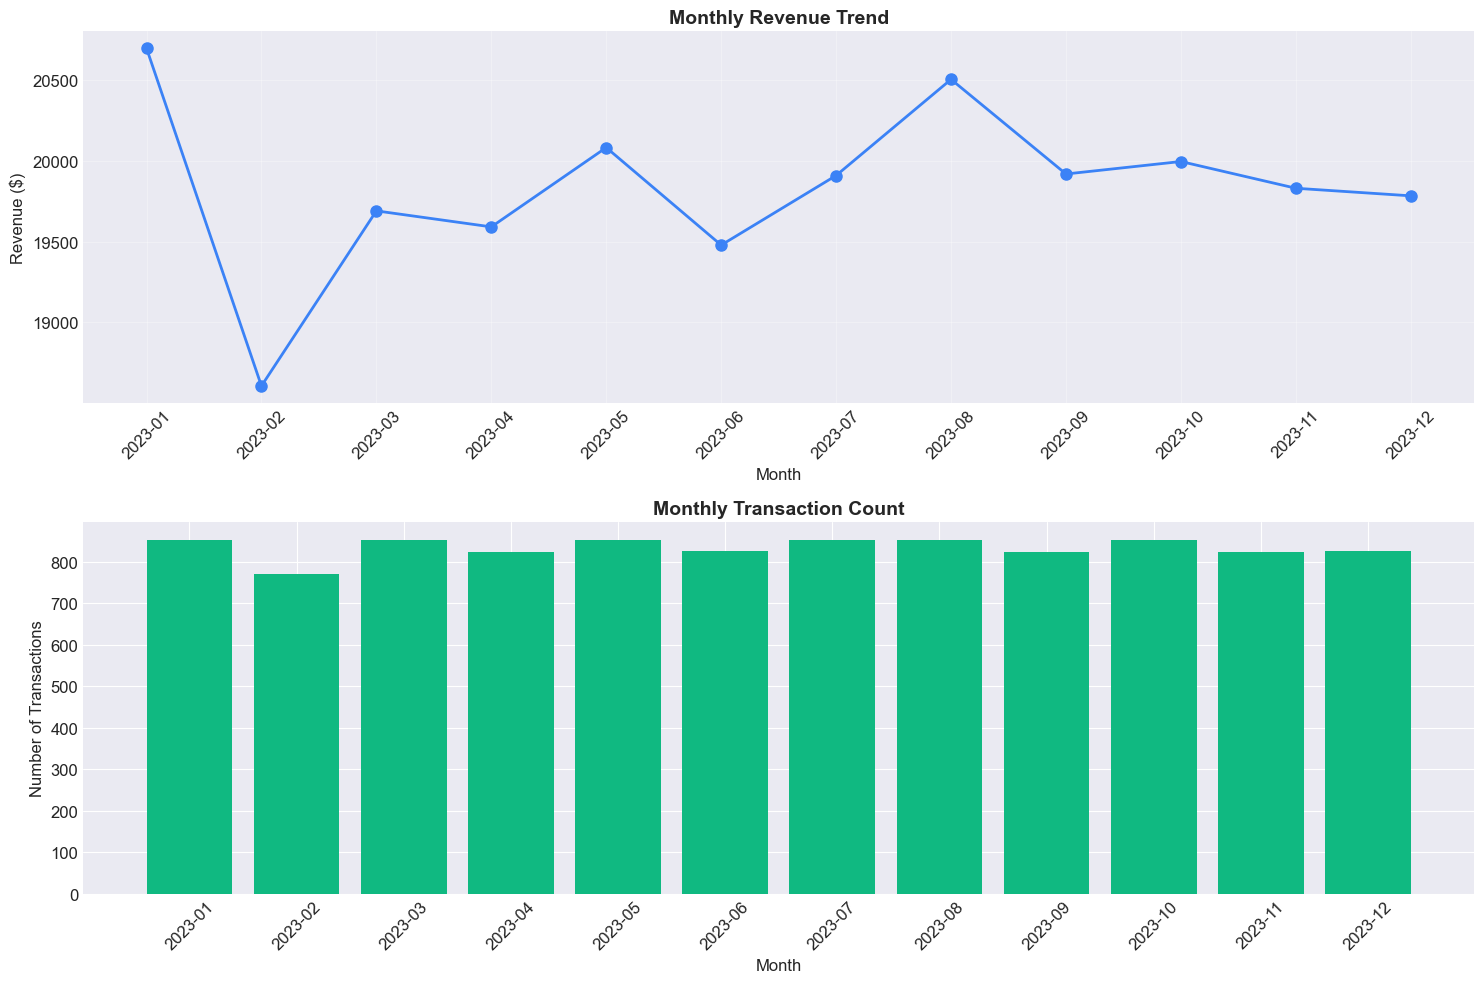


📅 WEEKDAY ANALYSIS


,sum,count,mean
Weekday,,,
Monday,33261.22,1428,23.292171
Tuesday,34504.12,1429,24.145640
Wednesday,34022.17,1428,23.825049
Thursday,33889.09,1429,23.715248
Friday,34336.99,1428,24.045511
Saturday,33758.88,1428,23.640672
Sunday,34316.96,1430,23.997874


In [8]:
# Extract date components
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['Month'] = df['InvoiceDate'].dt.month
df['MonthName'] = df['InvoiceDate'].dt.strftime('%B')
df['Weekday'] = df['InvoiceDate'].dt.day_name()

# Monthly revenue aggregation
monthly_revenue = df.groupby('YearMonth')['NetRevenue'].agg(['sum', 'count', 'mean']).reset_index()
monthly_revenue.columns = ['Month', 'Total_Revenue', 'Transaction_Count', 'Avg_Transaction']
monthly_revenue['Month'] = monthly_revenue['Month'].astype(str)

print("📈 MONTHLY TRENDS")
print("=" * 50)
monthly_revenue

# Plot monthly trends
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Revenue trend
axes[0].plot(monthly_revenue['Month'], monthly_revenue['Total_Revenue'], 
             marker='o', linewidth=2, markersize=8, color='#3B82F6')
axes[0].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue ($)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Transaction count trend
axes[1].bar(monthly_revenue['Month'], monthly_revenue['Transaction_Count'], color='#10B981')
axes[1].set_title('Monthly Transaction Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Transactions')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Weekday analysis
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_revenue = df.groupby('Weekday')['NetRevenue'].agg(['sum', 'count', 'mean']).reindex(weekday_order)

print("\n📅 WEEKDAY ANALYSIS")
print("=" * 50)
weekday_revenue

Product analysis

🏆 TOP 10 PRODUCTS BY REVENUE


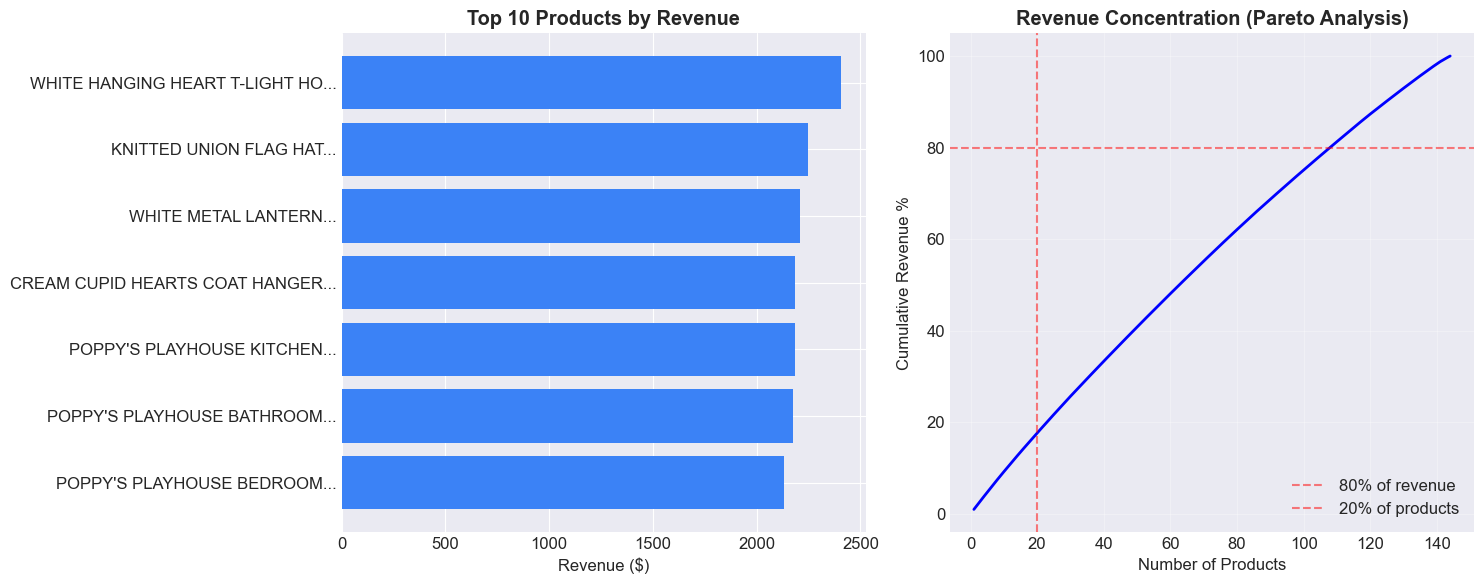


📊 PARETO ANALYSIS
Top 20% of products (28) generate 24.1% of revenue


In [9]:
# Product performance
product_performance = df.groupby(['StockCode', 'Description']).agg({
    'NetRevenue': 'sum',
    'Quantity': 'sum',
    'InvoiceNo': 'nunique'
}).rename(columns={
    'NetRevenue': 'Total_Revenue',
    'Quantity': 'Total_Quantity',
    'InvoiceNo': 'Transaction_Count'
}).reset_index()

product_performance['Avg_Price'] = product_performance['Total_Revenue'] / product_performance['Total_Quantity']

# Top 10 products by revenue
top_products = product_performance.nlargest(10, 'Total_Revenue')

print("🏆 TOP 10 PRODUCTS BY REVENUE")
print("=" * 50)
top_products[['Description', 'Total_Revenue', 'Total_Quantity', 'Transaction_Count', 'Avg_Price']]

# Visualize top products
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Revenue concentration
axes[0].barh(top_products['Description'].str[:30] + '...', top_products['Total_Revenue'], color='#3B82F6')
axes[0].set_title('Top 10 Products by Revenue', fontweight='bold')
axes[0].set_xlabel('Revenue ($)')
axes[0].invert_yaxis()

# Pareto analysis (80/20 rule)
sorted_revenue = product_performance.sort_values('Total_Revenue', ascending=False)['Total_Revenue']
cumulative = sorted_revenue.cumsum() / sorted_revenue.sum() * 100

axes[1].plot(range(1, len(cumulative)+1), cumulative, 'b-', linewidth=2)
axes[1].axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80% of revenue')
axes[1].axvline(x=20, color='r', linestyle='--', alpha=0.5, label='20% of products')
axes[1].set_title('Revenue Concentration (Pareto Analysis)', fontweight='bold')
axes[1].set_xlabel('Number of Products')
axes[1].set_ylabel('Cumulative Revenue %')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate concentration
top_20_pct_count = int(len(product_performance) * 0.2)
top_20_revenue = product_performance.nlargest(top_20_pct_count, 'Total_Revenue')['Total_Revenue'].sum()
total_revenue = product_performance['Total_Revenue'].sum()
concentration = (top_20_revenue / total_revenue) * 100

print(f"\n📊 PARETO ANALYSIS")
print(f"Top 20% of products ({top_20_pct_count}) generate {concentration:.1f}% of revenue")

Customer analysis

👥 CUSTOMER ANALYSIS
Total Customers: 501
Average Customer Value: $475.23
Median Customer Value: $447.06
One-time Customers: 0 (0.0%)


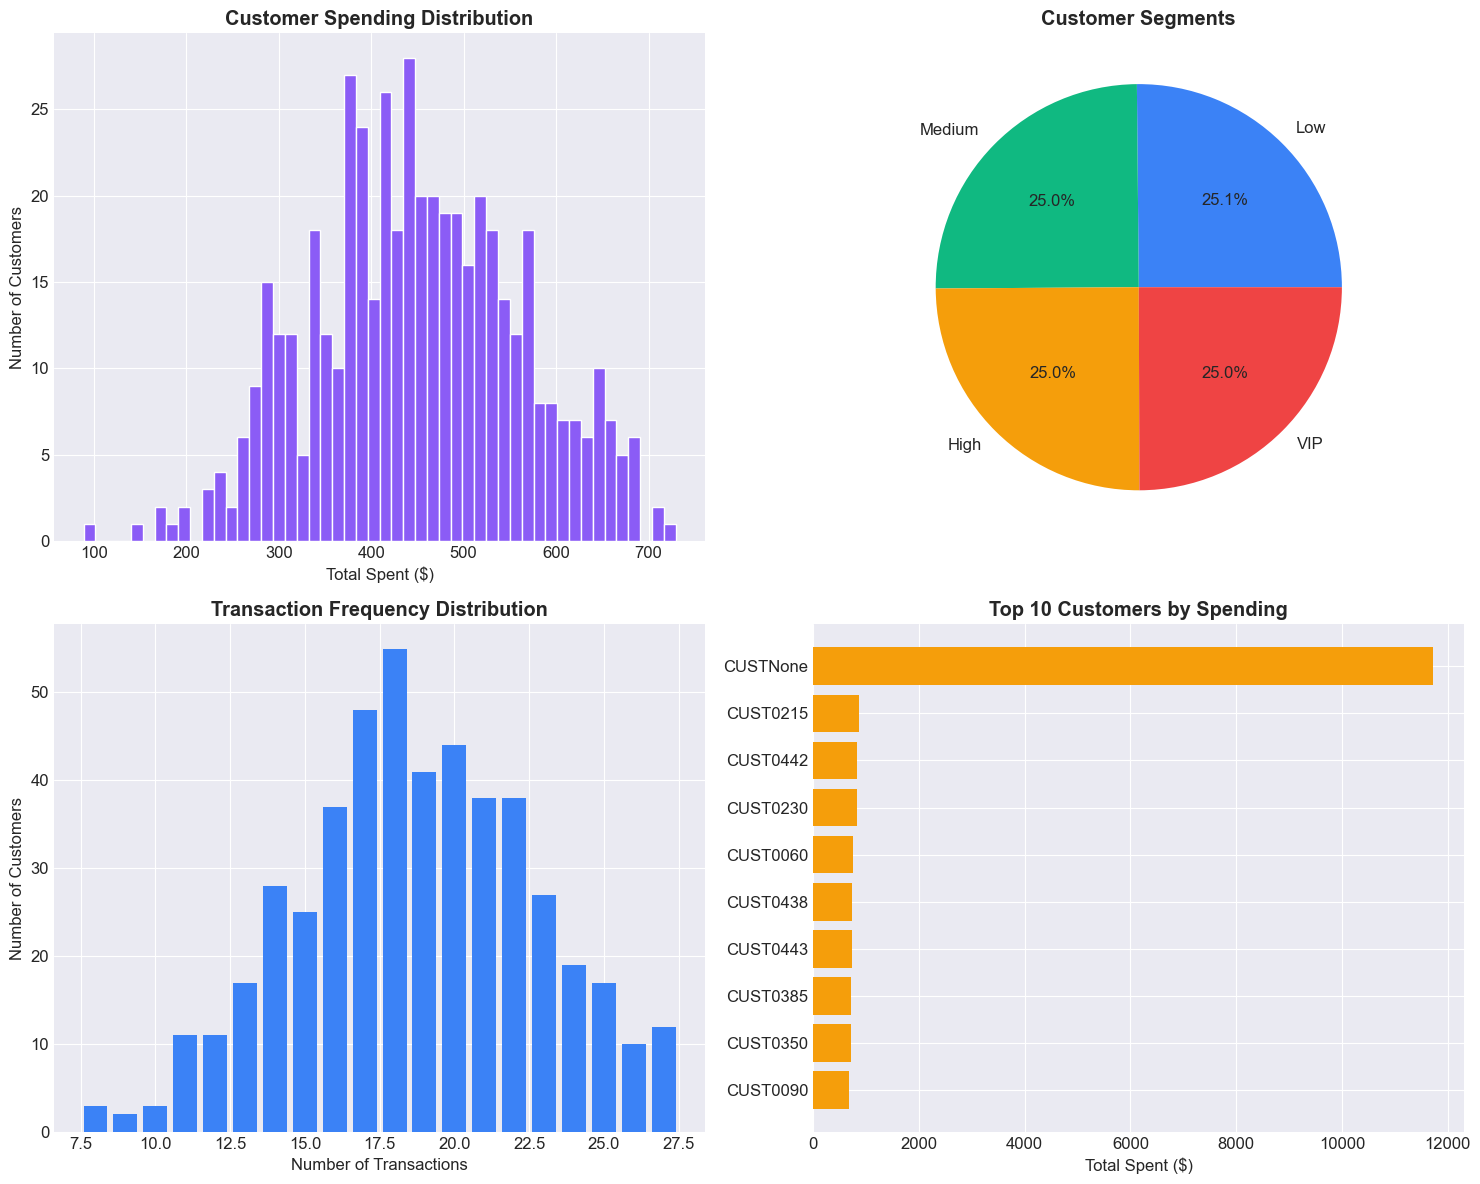


📊 CUSTOMER METRICS SUMMARY


,Total_Spent,Transaction_Count,Total_Items,Avg_Transaction
count,501.000000,501.000000,501.000000,501.000000
mean,475.228403,19.960080,192.702595,23.868277
std,517.478650,21.912061,209.630287,3.601460
min,88.920000,8.000000,37.000000,11.115000
25%,375.280000,16.000000,151.000000,21.344815
50%,447.060000,19.000000,181.000000,23.954545
75%,531.740000,22.000000,215.000000,26.353333
max,11730.140000,500.000000,4755.000000,35.541818


In [10]:
# Filter out unknown customers
customer_df = df[df['CustomerID'] != 'Unknown']

# Customer metrics
customer_metrics = customer_df.groupby('CustomerID').agg({
    'NetRevenue': 'sum',
    'InvoiceNo': 'nunique',
    'Quantity': 'sum'
}).rename(columns={
    'NetRevenue': 'Total_Spent',
    'InvoiceNo': 'Transaction_Count',
    'Quantity': 'Total_Items'
})

customer_metrics['Avg_Transaction'] = customer_metrics['Total_Spent'] / customer_metrics['Transaction_Count']

print("👥 CUSTOMER ANALYSIS")
print("=" * 50)
print(f"Total Customers: {len(customer_metrics):,}")
print(f"Average Customer Value: ${customer_metrics['Total_Spent'].mean():,.2f}")
print(f"Median Customer Value: ${customer_metrics['Total_Spent'].median():,.2f}")
print(f"One-time Customers: {(customer_metrics['Transaction_Count'] == 1).sum():,} ({(customer_metrics['Transaction_Count'] == 1).mean()*100:.1f}%)")

# Customer segmentation
customer_metrics['Segment'] = pd.qcut(
    customer_metrics['Total_Spent'], 
    q=4, 
    labels=['Low', 'Medium', 'High', 'VIP'],
    duplicates='drop'
)

segment_dist = customer_metrics['Segment'].value_counts()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Customer spending distribution
spending_99 = customer_metrics['Total_Spent'].quantile(0.99)
normal_spending = customer_metrics[customer_metrics['Total_Spent'] < spending_99]

axes[0, 0].hist(normal_spending['Total_Spent'], bins=50, color='#8B5CF6', edgecolor='white')
axes[0, 0].set_title('Customer Spending Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Total Spent ($)')
axes[0, 0].set_ylabel('Number of Customers')

# 2. Customer segments pie chart
axes[0, 1].pie(segment_dist.values, labels=segment_dist.index, autopct='%1.1f%%', 
               colors=['#3B82F6', '#10B981', '#F59E0B', '#EF4444'])
axes[0, 1].set_title('Customer Segments', fontweight='bold')

# 3. Transaction frequency
freq_dist = customer_metrics['Transaction_Count'].value_counts().sort_index().head(20)
axes[1, 0].bar(freq_dist.index, freq_dist.values, color='#3B82F6')
axes[1, 0].set_title('Transaction Frequency Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Number of Transactions')
axes[1, 0].set_ylabel('Number of Customers')

# 4. Top 10 customers
top_10_customers = customer_metrics.nlargest(10, 'Total_Spent')
axes[1, 1].barh(range(10), top_10_customers['Total_Spent'].values, color='#F59E0B')
axes[1, 1].set_yticks(range(10))
axes[1, 1].set_yticklabels([f'CUST{str(i)[-4:]}' for i in top_10_customers.index])
axes[1, 1].set_title('Top 10 Customers by Spending', fontweight='bold')
axes[1, 1].set_xlabel('Total Spent ($)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# RFM-style metrics
print("\n📊 CUSTOMER METRICS SUMMARY")
print("=" * 50)
customer_metrics.describe()

In [11]:
print("🔍 KEY BUSINESS INSIGHTS")
print("=" * 60)

# Revenue insights
print("\n💰 REVENUE:")
print(f"  • Total Revenue: ${net_revenue:,.2f}")
print(f"  • Return Rate: {return_rate:.2f}%")
print(f"  • Avg Transaction Value: ${df['NetRevenue'].mean():,.2f}")

# Customer insights
one_time_pct = (customer_metrics['Transaction_Count'] == 1).mean() * 100
print("\n👥 CUSTOMERS:")
print(f"  • Total Customers: {len(customer_metrics):,}")
print(f"  • One-time Buyers: {one_time_pct:.1f}%")
print(f"  • Avg Customer Value: ${customer_metrics['Total_Spent'].mean():,.2f}")

# Product insights
print("\n📦 PRODUCTS:")
print(f"  • Total Products: {len(product_performance):,}")
print(f"  • Top Product: {top_products.iloc[0]['Description']}")
print(f"  • Top Product Revenue: ${top_products.iloc[0]['Total_Revenue']:,.2f}")
print(f"  • Revenue Concentration: {concentration:.1f}% from top 20% of products")

# Time insights
best_day = weekday_revenue['sum'].idxmax()
best_day_value = weekday_revenue['sum'].max()
print("\n📅 TIMING:")
print(f"  • Best Performing Day: {best_day} (${best_day_value:,.2f})")
print(f"  • Data Span: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days} days")

🔍 KEY BUSINESS INSIGHTS

💰 REVENUE:
  • Total Revenue: $238,089.43
  • Return Rate: 2.02%
  • Avg Transaction Value: $23.81

👥 CUSTOMERS:
  • Total Customers: 501
  • One-time Buyers: 0.0%
  • Avg Customer Value: $475.23

📦 PRODUCTS:
  • Total Products: 144
  • Top Product: WHITE HANGING HEART T-LIGHT HOLDER
  • Top Product Revenue: $2,404.15
  • Revenue Concentration: 24.1% from top 20% of products

📅 TIMING:
  • Best Performing Day: Tuesday ($34,504.12)
  • Data Span: 364 days
